In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import hvplot.pandas
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from fuzzywuzzy import process
import requests

In [3]:
r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
stockList = r.json()


In [4]:
#load model for results
model = load('project2_random_forest_model.joblib')

In [5]:
company_request = 'tesla'

In [6]:
def getCompany(text):
    return process.extractOne(text, stockList)[0]

In [7]:
company = getCompany(company_request)

In [8]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

TSLA
TESLA INC


In [9]:
cash_amount = '500000'

In [10]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 downloaded


In [11]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [12]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

# Set the short window and long windows
rolling_short_window = 50
rolling_long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
data["SMA50"] = data["Close"].rolling(window=short_window).mean()
data["SMA100"] = data["Close"].rolling(window=long_window).mean()

# Initialize the new `Signal` column
data["SMA_Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
data["SMA_Signal"][short_window:] = np.where(
    data["SMA50"][short_window:] < data["SMA100"][short_window:], 1.0, 0.0
)

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300,NaN,23.890000,23.890000,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512,23.859792,23.859896,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473,23.217729,23.222203,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683,22.192315,22.206173,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937,20.941893,20.969978,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


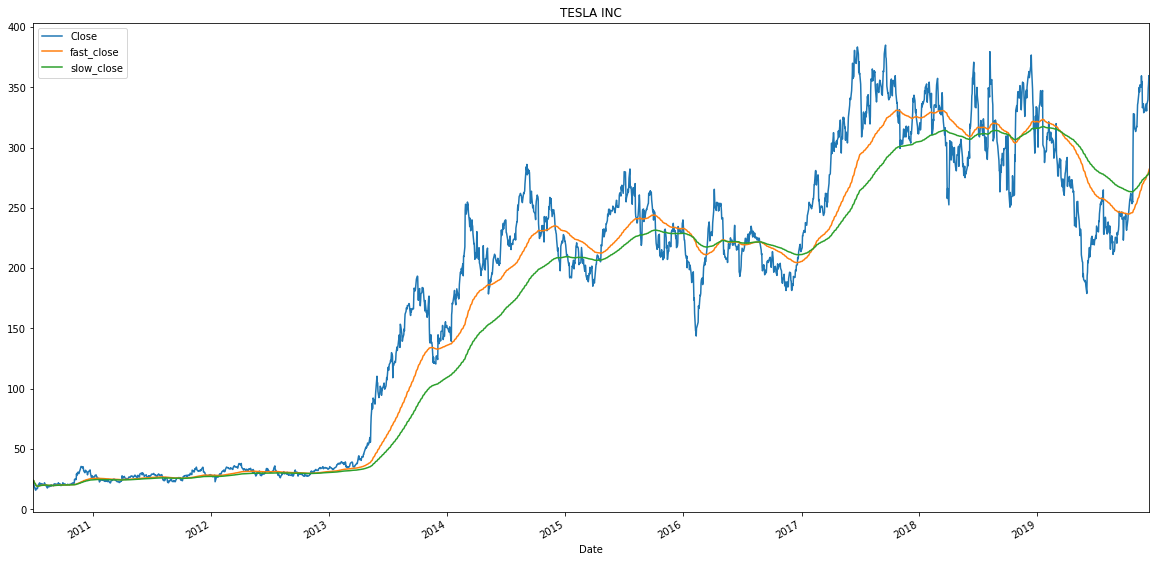

In [13]:
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

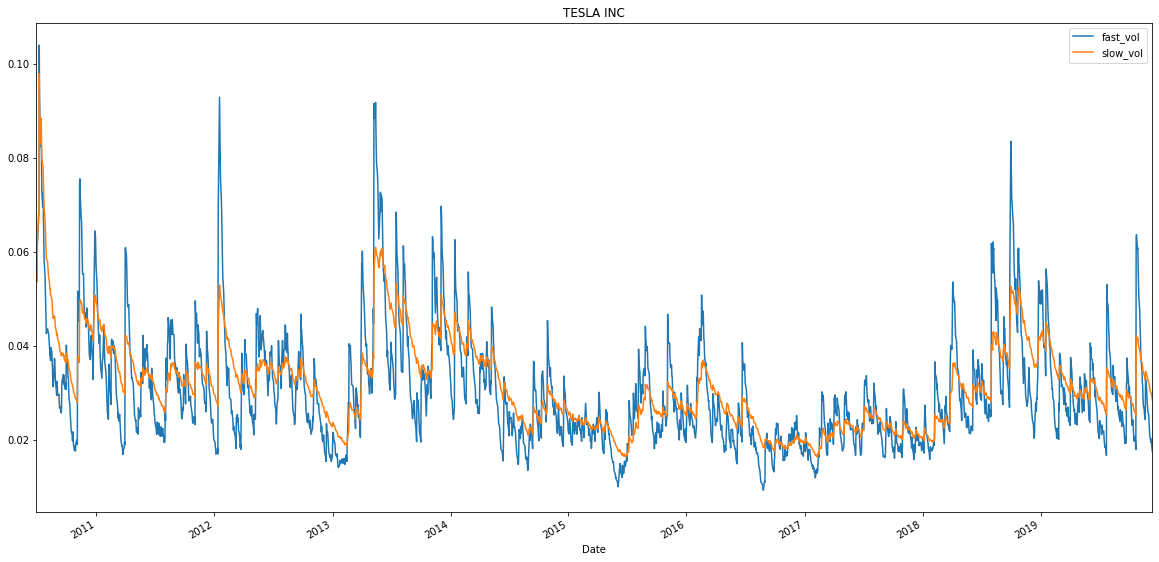

In [14]:
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

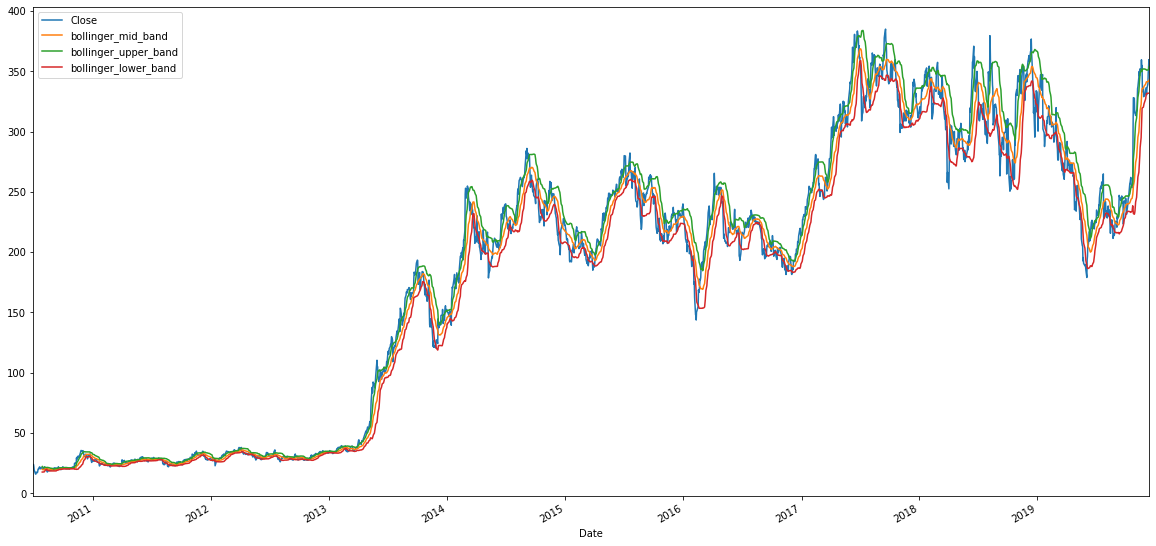

In [15]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [16]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'SMA_Signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-09,1.0,1.0,0.0,0.0
2019-12-10,1.0,1.0,0.0,0.0
2019-12-11,1.0,1.0,-1.0,0.0
2019-12-12,1.0,1.0,-1.0,0.0
2019-12-13,1.0,1.0,-1.0,0.0


In [17]:
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-09,1.0,1.0,0.0,0.0
2019-12-10,1.0,1.0,0.0,0.0
2019-12-11,1.0,1.0,0.0,0.0
2019-12-12,1.0,1.0,-1.0,0.0
2019-12-13,1.0,1.0,-1.0,0.0


In [18]:
#signal_dataand replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512,23.859792,23.859896,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473,23.217729,23.222203,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683,22.192315,22.206173,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937,20.941893,20.969978,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2010-07-07,16.40,16.63,14.98,15.80,15.80,6921700,-0.019243,20.054938,20.093315,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


In [19]:
data['Positive Return'] = np.where(data['Daily Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512,23.859792,23.859896,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473,23.217729,23.222203,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683,22.192315,22.206173,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937,20.941893,20.969978,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2010-07-07,16.40,16.63,14.98,15.80,15.80,6921700,-0.019243,20.054938,20.093315,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,336.59,344.45,335.08,339.53,339.53,9023100,0.010837,277.820465,277.335008,1.0,...,9.644577,351.076077,331.786923,0.0,0.0,0.0,302.8584,268.1495,0.0,1.0
2019-12-10,339.96,350.73,339.31,348.84,348.84,8828300,0.027420,278.798212,277.828929,1.0,...,9.755262,351.374262,331.863738,0.0,0.0,0.0,305.0178,269.0561,0.0,1.0
2019-12-11,351.88,357.19,351.09,352.70,352.70,6897800,0.011065,279.815639,278.346101,1.0,...,9.898085,351.655585,331.859415,0.0,-1.0,0.0,307.1780,270.0263,0.0,1.0


In [20]:
# Construct training start and end dates
start_date = data.index.min().strftime(format= '%Y-%m-%d')
end_date = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Start: {start_date}")
print(f"End: {end_date}")

Start: 2010-06-30
End: 2019-12-13


In [21]:
# Construct the datasets
x_data = data[x_var_list][start_date:end_date]

# Predictions

In [22]:
predictions = model.predict(x_data)
predictions

array([1., 1., 1., ..., 1., 0., 0.])

In [23]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
data["Predicted Value"] = predictions
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Predicted Value
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512,23.859792,23.859896,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473,23.217729,23.222203,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683,22.192315,22.206173,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937,20.941893,20.969978,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
2010-07-07,16.40,16.63,14.98,15.80,15.80,6921700,-0.019243,20.054938,20.093315,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,336.59,344.45,335.08,339.53,339.53,9023100,0.010837,277.820465,277.335008,1.0,...,351.076077,331.786923,0.0,0.0,0.0,302.8584,268.1495,0.0,1.0,1.0
2019-12-10,339.96,350.73,339.31,348.84,348.84,8828300,0.027420,278.798212,277.828929,1.0,...,351.374262,331.863738,0.0,0.0,0.0,305.0178,269.0561,0.0,1.0,1.0
2019-12-11,351.88,357.19,351.09,352.70,352.70,6897800,0.011065,279.815639,278.346101,1.0,...,351.655585,331.859415,0.0,-1.0,0.0,307.1780,270.0263,0.0,1.0,1.0


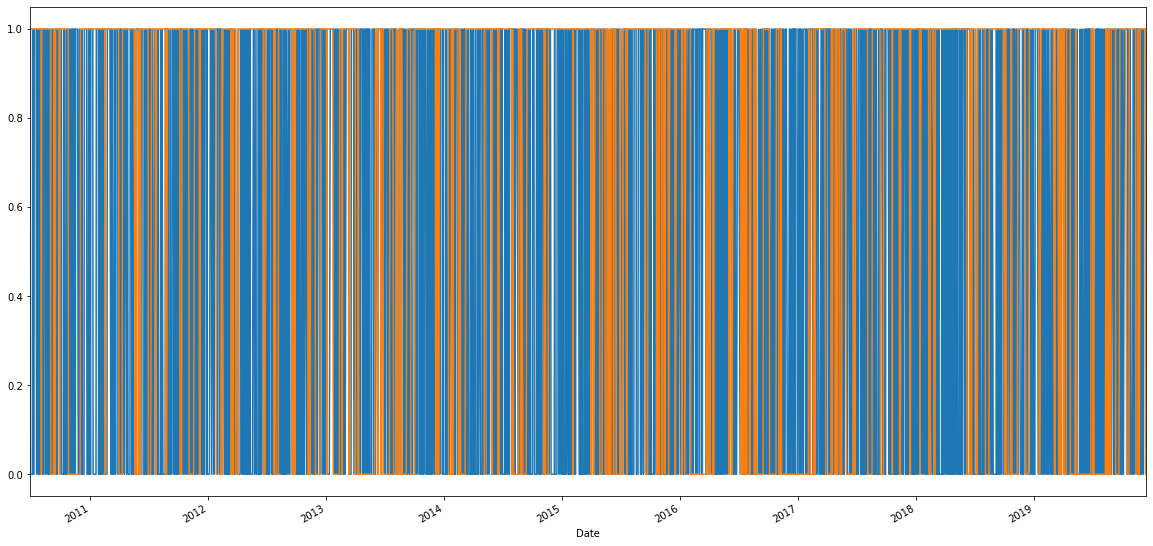

In [24]:
data['Positive Return'][start_date:end_date].plot(figsize=(20,10))
data['Predicted Value'][start_date:end_date].plot(figsize=(20,10))

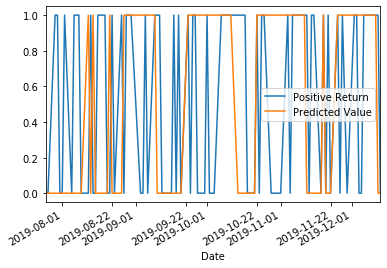

In [25]:
data[['Positive Return', 'Predicted Value']].tail(100).plot()

In [26]:
# Calculate the points in time at which a position should be taken, 1 or -1
data["Entry/Exit"] = data["Predicted Value"].diff()

In [27]:
#Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = data[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = data[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [30]:
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Predicted Value,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512,23.859792,23.859896,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,NaN
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473,23.217729,23.222203,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683,22.192315,22.206173,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937,20.941893,20.969978,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0
2010-07-07,16.40,16.63,14.98,15.80,15.80,6921700,-0.019243,20.054938,20.093315,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,336.59,344.45,335.08,339.53,339.53,9023100,0.010837,277.820465,277.335008,1.0,...,331.786923,0.0,0.0,0.0,302.8584,268.1495,0.0,1.0,1.0,0.0
2019-12-10,339.96,350.73,339.31,348.84,348.84,8828300,0.027420,278.798212,277.828929,1.0,...,331.863738,0.0,0.0,0.0,305.0178,269.0561,0.0,1.0,1.0,0.0
2019-12-11,351.88,357.19,351.09,352.70,352.70,6897800,0.011065,279.815639,278.346101,1.0,...,331.859415,0.0,-1.0,0.0,307.1780,270.0263,0.0,1.0,1.0,0.0


In [31]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Return',
       'fast_close', 'slow_close', 'crossover_long', 'crossover_short',
       'crossover_signal', 'fast_vol', 'slow_vol', 'vol_trend_long',
       'vol_trend_short', 'vol_trend_signal', 'bollinger_mid_band',
       'bollinger_std', 'bollinger_upper_band', 'bollinger_lower_band',
       'bollinger_long', 'bollinger_short', 'bollinger_signal', 'SMA50',
       'SMA100', 'SMA_Signal', 'Positive Return', 'Predicted Value',
       'Entry/Exit'],
      dtype='object')

# PORTFOLIO ANALYSER

In [32]:
#Need to figure out share size based on captial divided by close cost - integer 
#for loop o it always takes the last know value to get latest share size
#for loop through proces

In [37]:
# Grab just the `date` and `close` from the IEX dataset
signals_df = data.loc[:, ['Entry/Exit', 'Close']].copy()

# # Set the `date` column as the index
# signals_df = signals_df.set_index("date", drop=True)

# # Set the short window and long windows
# short_window = 50
# long_window = 100

# # Generate the short and long moving averages (50 and 100 days, respectively)
# signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
# signals_df['SMA100'] = signals_df['close'].rolling(window=long_window).mean()
# signals_df['Signal'] = 0.0

# # Generate the trading signal 0 or 1,
# # where 0 is when the SMA50 is under the SMA100, and
# # where 1 is when the SMA50 is higher (or crosses over) the SMA100
# signals_df['Signal'][short_window:] = np.where(
#     signals_df['SMA50'][short_window:] > signals_df['SMA100'][short_window:], 1.0, 0.0
# )

# Calculate the points in time at which a position should be taken, 1 or -1
#signals_df['Entry/Exit'] = signals_df['Entry/Exit'].diff()

# Print the DataFrame
signals_df

,Entry/Exit,Close
Date,,
2010-06-30,NaN,23.83
2010-07-01,0.0,21.96
2010-07-02,0.0,19.20
2010-07-06,0.0,16.11
2010-07-07,0.0,15.80
...,...,...
2019-12-09,0.0,339.53
2019-12-10,0.0,348.84
2019-12-11,0.0,352.70


In [38]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals_df['Position'] = share_size * signals_df['Entry/Exit']

# Find the points in time where a 500 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals_df

,Entry/Exit,Close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,
2010-06-30,NaN,23.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,0.0,21.96,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-02,0.0,19.20,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN
2010-07-06,0.0,16.11,0.0,0.0,0.0,100000.0,100000.0,0.00000,0.00000
2010-07-07,0.0,15.80,0.0,0.0,0.0,100000.0,100000.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...
2019-12-09,0.0,339.53,0.0,0.0,0.0,94305.0,94305.0,0.00000,-0.05695
2019-12-10,0.0,348.84,0.0,0.0,0.0,94305.0,94305.0,0.00000,-0.05695
2019-12-11,0.0,352.70,0.0,0.0,0.0,94305.0,94305.0,0.00000,-0.05695


In [39]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

In [ ]:
# Set initial capital
initial_capital = float(cash_amount)

# Set the share size
share_size = 500 

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
data['Position'] = share_size * data['Entry/Exit']

# Find the points in time where a 500 share position is bought or sold
data['Entry/Exit Position'] = data['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
data['Portfolio Holdings'] = data['Close'] * data['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
data['Portfolio Cash'] = initial_capital - (data['Close'] * data['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
data['Portfolio Total'] = data['Portfolio Cash'] + data['Portfolio Holdings']

# Calculate the portfolio daily returns
data['Portfolio Daily Returns'] = data['Portfolio Total'].pct_change()

# Calculate the cumulative returns
data['Portfolio Cumulative Returns'] = (1 + data['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
data.tail(10)

In [ ]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry/Exit',
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

In [ ]:
data.columns

In [ ]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_exit = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0


# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in data.iterrows():
    if row['Entry/Exit'] == 1:
        entry_exit = row['Entry/Exit'] 
        entry_date = index
        entry_portfolio_holding = row['Portfolio Holdings']
        share_size = row['Entry/Exit Position']
        entry_share_price = row['Close']

    elif row['Entry/Exit'] == -1:
        entry_exit = row['Entry/Exit'] 
        exit_date = index
        exit_portfolio_holding = abs(row['Close'] * row['Entry/Exit Position'])
        exit_share_price = row['Close']
        profit_loss = exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': symbol,
                'Entry/Exit': entry_exit,
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

In [ ]:
# Visualize exit position relative to total portfolio value
exit = trade_evaluation_df[trade_evaluation_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = trade_evaluation_df[trade_evaluation_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = trade_evaluation_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None)